In [2]:
##Import packages

import subprocess
import numpy as np
import os, sys, shutil
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

import pandas as pd
import gc
import math
import time

from sklearn.cluster import KMeans

%matplotlib inline

In [3]:
def gaussian(x,mu,sig):
    return np.exp(-((x-mu)**2)/(2*sig**2))

In [4]:
# 0. Import## Identify all water molecules
def distance(box, atom, aim_pool):
    vecs = abs(np.array(aim_pool, dtype='float')-np.array(atom, dtype='float'))
    for i in range(3):
        vecs[:,i] = np.minimum(vecs[:,i],box[i]-vecs[:,i])
    distance = np.linalg.norm(vecs,axis=1)
    return distance
def findNearest(box, atom, aim_pool, num):
    """
    Find the nearest one to given atom from a group of candidate
    Input: 
        box: periodic box size
        atom: given atom (position, dimention=3d)
        aim pool: a list of positions.
    Return:
        index of closest atom in aim_pool
    
    """
    vecs = abs(np.array(aim_pool, dtype='float')-np.array(atom, dtype='float'))
    for i in range(3):
        vecs[:,i] = np.minimum(vecs[:,i],box[i]-vecs[:,i])
    distance = np.linalg.norm(vecs,axis=1)
    sorted_dis = sorted(distance)
    res = np.where(distance <= sorted_dis[num])[0]
    if len(res)>num:
        res = np.concatenate((np.where(distance < sorted_dis[num])[0],np.where(distance == sorted_dis[num])[0]))
        res = res[:num]
    return res

In [5]:
def water_form(lines, eles, box):  # , res_type = 'idxs'):
    #mol_type_class = {'-OH in H3PO4':6, '-O in H3PO4':7, 'hydronium-AAA':4, 
    #                    'water-DDA':2, 'water-DA':0, 'water-DDAA':3, 'water-DAA':1}
    mol_type_class = {'-OH in H3PO4':6, '-O in H3PO4':7, 'hydronium-AAA':4, 
                        'water-DDA':2, 'water-DA':0, 'water-DDAA':3, 'water-DAA':1}
    
    pos = [[float(_e) for _e in e.split()] for e in lines[1:]]
    pos = np.array(pos, dtype = 'object')
    atoms = np.concatenate((eles, pos),axis=1)
    for i in range(len(box)):
        atoms[:,i+1] = atoms[:,i+1]*box[i]
        
    Oinds = np.where(atoms[:,0]=='O')[0]
    Hinds = np.where(atoms[:,0]=='H')[0]
    Linds = np.where(atoms[:,0]=='Li')[0]
    Cinds = np.where(atoms[:,0]=='Cl')[0]

    Os = atoms[Oinds,1:]
    Hs = atoms[Hinds,1:]
    Ls = atoms[Linds,1:]
    Cs = atoms[Cinds,1:]

    
    '''
    pair_coeff 1 1 0.07647 2.126 # Li
    pair_coeff 2 2 0.4928 4.417 # Cl
    pair_coeff 3 3 0.1553 3.166      # O
    pair_coeff 4 4 0.0460    0.4000      # H
    pair_coeff 3 4 0.0    0.0 #OH
    
    '''
    OH_cutoff = 1.28
    O_H_cutoff = 2.25     # O...H < 2.25 
    O_Li_cutoff = 2.33  
    H_Cl_cutoff = 2.441  
    OO_cutoff = 3.4       # O-O < 3.4 A   
    
    # H_Cl
    # https://pubs.acs.org/doi/10.1021/jp310596c
    # H-Cl: 2.441        O-H...Cl 119.0
        
    mol = []
    OO_mat = np.zeros(( len(Os) , len(Os) ))
    HinWater = np.zeros(( len(Os) , 2 , 3 ))
    


    for i in range(len(Os)):
        temp = distance(box, Os[i], Os)
        for _i in np.where(temp<=OO_cutoff)[0]:
            if i == _i:
                continue
            OO_mat[i,_i] = 1
        HinWater[i] = Hs[findNearest(box, Os[i], Hs, 2)]
    for i in range(len(Os)):
        
        ## A
        pot_Os = Os[np.where(OO_mat[i]==1)[0]]
        
        pot_Hs = np.concatenate(HinWater[np.where(OO_mat[i]==1)[0]])
        temp_OH = distance(box, Os[i], pot_Hs)
        No_O_H = len(np.where(temp_OH<O_H_cutoff)[0])
        
        t = []
        t.append(No_O_H)
        
        
        ## D
        doner_H = 0
        #print(i)
        for _H in HinWater[i]:
            temp_HO = distance(box, _H, pot_Os)
            #print(sorted(temp_HO))
            temp_HO = np.where(temp_HO<O_H_cutoff)[0]
            doner_H += (len(temp_HO))
        t.append(doner_H)
        
        ## A-Li
        temp_OL = distance(box, Os[i], Ls)
        OL_idx = np.where(temp_OL<O_Li_cutoff)[0]
        No_OL = len(OL_idx)
        t.append(No_OL)
        
        
        ## D-Cl
        doner_H = 0
        #print(i)
        for _H in HinWater[i]:
            temp_HC = distance(box, _H, Cs)
            #print(sorted(temp_HO))
            temp_HC = np.where(temp_HC<H_Cl_cutoff)[0]
            doner_H += (len(temp_HC)-1)
        #print(doner_H)
        t.append(doner_H)
        
        mol.append(t)
        
    mol = np.array(mol,dtype='object')
    
    mol_type = ['']*len(Os)
    for i, wat in enumerate(mol):
        temp = ''
        temp = temp+'C'*wat[3]
        temp = temp+'D'*wat[1]
        temp = temp+'A'*wat[0]
        temp = temp+'L'*wat[2]
        mol_type[i] = temp
        '''
        if res_type == 'idxs':
            if temp not in mol_type_class:
                mol_type[i] = 5
            else:
                mol_type[i] = mol_type_class[temp]
        else:
            mol_type[i] = temp
        '''
    return mol_type

In [6]:
def generate_data(data_path = '/rhome/wzhan097/bigdata/LiCl_testRun/_history',
                  filename = 'XDATCAR05'
):
    
    
    with open(os.path.join(data_path,filename),'r') as f:
        lines = f.readlines()
    box = lines[2:5]
    box =[e.split() for e in box]
    box = [box[0][0],box[1][1],box[2][2]]
    box = [float(e) for e in box]
    lines = lines[5:]
    types = lines[0].split()
    temp = lines[1].split()
    temp = [int(e) for e in temp]
    eles = []
    atom_num = sum(temp)

    for _i,_j in zip(types, temp):
        eles = eles+[[_i]]*_j
    eles = np.array(eles, dtype = 'object')
    lines = lines[2:]
    pos_period = []
    for i in range( 0,int(len(lines)/(atom_num+1)) ):
        
        _lines = lines[i*(atom_num+1):(i+1)*(atom_num+1)]
        pos = [[float(_e) for _e in e.split()] for e in _lines[1:]]
        pos = np.array(pos, dtype = 'object')
        atoms = np.concatenate((eles, pos),axis=1)
        for i in range(len(box)):
            atoms[:,i+1] = atoms[:,i+1]*box[i]
        pos_period.append(atoms)
    return np.array(box), np.array(pos_period)
        

In [7]:
save_dir = '/rhome/wzhan097/bigdata/woochul/final_data_H3PO4'

In [ ]:
np.save(os.path.join(save_dir,'exam_02.npy'),x)
np.save(os.path.join(save_dir,'exam_02_box.npy'),b)

In [ ]:
###functions for PDF ganeration

def PDF_partial(atoms, box, eles,
                            r = np.arange(0.5, 6, 0.02), if_plot=True):
    #bi is num of electron of i
    #G(r) = 4pir (2/N * sum of i and j(bi*bj/b^2) at rij=r - V/N)
    r_cutoff = max(r)
    
    box = np.array(box)
    
    
    b_dic={'Li':29, 'Cl':6, 'H':1, 'O':8}
    b_dic={'Li':1, 'Cl':1, 'H':1, 'O':1}
    
    b_l = np.array([b_dic[e] for e in eles])
    
    b_ave = sum([b_dic[e] for e in atoms[:,0]])/len(atoms)
    
    V = 1
    for l in box:
        V = V*l
    N = len(atoms)
    p0 = N/V
    
    def __f__(x, mu, sig):
        return np.exp(-np.power(x - mu, 2.) / (np.power(sig, 2.)))/(4*sig*np.power(math.pi, 1.5)*np.power(mu, 2))
    
    
    def __Gij_r__(bi, bj, rij, r, b=b_ave, width = 0.1):
        #return (bi*bj/b/b)*sum(__f__(r, rij,width))/__f__(1, 1,width)
        return (bi*bj/b/b)*sum(gaussian(r, rij,width))
    
    def __G_r_e__(e1, e2):
        
        inds_1 = np.where(atoms[:,0]==e1)[0]
        inds_2 = np.where(atoms[:,0]==e2)[0]

        pos_1 = atoms[inds_1,1:]
        pos_2 = atoms[inds_2,1:]
        
        _r_s = []
        for pos in pos_1:
            _r_s = np.concatenate((_r_s,distance(box, pos, pos_2)))
        _r_s = _r_s[_r_s!=0]
        _r_s = _r_s[_r_s<=r_cutoff]
        res = [0]*len(r)
        for _i, _r in enumerate(r):
            res[_i] = __Gij_r__(b_dic[e1], b_dic[e2], _r_s, _r, b=b_ave, width=0.08)#/_r #  - (4*math.pi*_r*p0)
    
        return res
    
    res = __G_r_e__(eles[0], eles[1])
    if if_plot:
        plt.plot(r, res)
        plt.show()
        
    return res

In [ ]:
b, x = generate_data()
_rs = np.arange(0.5, 6, 0.02)
res = np.zeros(np.arange(0.5, 6, 0.02).shape)
for i, _x in enumerate(x):
    res+=PDF_partial(_x, b, ['Li','O'], if_plot = False)
    if i%500 == 0:
        print(i)
plt.plot(_rs, res)

In [133]:
b, x = generate_data(data_path='/rhome/wzhan097/shared/H3PO4_Weiyi/new_vasp_RT/00/_history', filename = 'XDATCAR02')

In [37]:
b, x = generate_data(data_path='/rhome/wzhan097/bigdata/LiCl_testRun_RT/_history', filename = 'XDATCAR04')
x = x[5000:]

In [38]:
for i in range(1,7):
    _, _x = generate_data(data_path='/rhome/wzhan097/bigdata/proton_battery/LiCl/25p_mass/RT/'+str(i)+'case/dft', filename = 'XDATCAR')
    x = np.concatenate((x,_x),axis = 0)

In [136]:
for i in range(1,7):
    _, _x = generate_data(data_path='/rhome/wzhan097/shared/H3PO4_Weiyi/new_vasp_RT/0'+str(i)+'/_history', filename = 'XDATCAR02')
    print(_x.shape)
    x = np.concatenate((x,_x),axis = 0)

(500, 306, 4)
(500, 306, 4)
(500, 306, 4)
(500, 306, 4)
(500, 306, 4)
(500, 306, 4)


In [140]:
x.shape

(700, 306, 4)

In [138]:
x = x.reshape((5,700, 306, 4))

In [139]:
x=x[0,:,:,:]

In [ ]:
pPDF = {'RT':{'x':[],'ys':{},'Tem':'293K'},'LT':{'x':[],'ys':{},'Tem':'195K'}}

In [ ]:
_rs = np.arange(0.5, 6, 0.02)
res_HCl = np.zeros(np.arange(0.5, 6, 0.02).shape)
for i, _x in enumerate(x_LT[-500:-300]):
    res_HCl+=np.array(PDF_partial(_x, b_LT, ['H','Cl'], if_plot = False))/200
    if i%500 == 0:
        print(i)
plt.plot(_rs, res_HCl)

In [ ]:
#b_RT, x_RT = generate_data(data_path = '/rhome/wzhan097/bigdata/LiCl_testRun_RT/_history',
#                  filename = 'XDATCAR04')

_rs = np.arange(0.5, 6, 0.02)
res_RT = np.zeros(np.arange(0.5, 6, 0.02).shape)
for i, _x in enumerate(x_RT):
    res_RT+=PDF_partial(_x, b, ['Li','O'], if_plot = False)
    if i%500 == 0:
        print(i)
plt.plot(_rs, res_RT)

In [ ]:
_rs = np.arange(0.5, 6, 0.02)
res_HCl_RT = np.zeros(np.arange(0.5, 6, 0.02).shape)
for i, _x in enumerate(x_RT):
    res_HCl_RT+=PDF_partial(_x, b_RT, ['H','Cl'], if_plot = False)
    if i%500 == 0:
        print(i)
plt.plot(_rs, res_HCl_RT)

In [ ]:
_rs = np.arange(0.5, 6, 0.02)
res_HCl_RT = np.zeros(np.arange(0.5, 6, 0.02).shape)
for i, _x in enumerate(x_RT):
    res_HCl_RT+=PDF_partial(_x, b_RT, ['H','Cl'], if_plot = False)
    if i%500 == 0:
        print(i)
plt.plot(_rs, res_HCl_RT)

In [ ]:
b_dic={'Li':29, 'Cl':16, 'H':1, 'O':8}
#b_dic={'Li':1, 'Cl':1, 'H':1, 'O':1}

b_ave = sum([b_dic[e] for e in x[0][:,0]])/len(x[0])

In [ ]:
sum(res_RT[_rs>5])/sum(res[_rs>5])

In [ ]:
plt.plot(_rs, [29*8/b_ave/b_ave*_x/_y/len(x_RT)/0.9157755842621367 - 4*math.pi*_y*302/(b[0]*b[1]*b[2]) for _x,_y in zip(res_RT,_rs)],'r',label = 'Li-O @ 293K')
plt.plot(_rs, [29*8/b_ave/b_ave*_x/_y/len(x_RT) - 4*math.pi*_y*302/(b[0]*b[1]*b[2]) for _x,_y in zip(res,_rs)],'black',label = 'Li-O @ 195K')
plt.ylim(-10,80)
plt.legend()
plt.title('Partial Pair Distribution Function')
plt.xlabel('r(Ang)')
plt.ylabel('G(r)')

In [ ]:
plt.plot(_rs, [17*5/b_ave/b_ave*_x/_y/len(x_RT)/0.9865460248236669 - 4*math.pi*_y*302/(b[0]*b[1]*b[2]) for _x,_y in zip(res_HCl_RT,_rs)],'r',label = 'H-Cl @ 293K')
plt.plot(_rs, [17*5/b_ave/b_ave*_x/_y/len(x_RT) - 4*math.pi*_y*302/(b[0]*b[1]*b[2]) for _x,_y in zip(res_HCl,_rs)],'black',label = 'H-Cl @ 195K')
plt.ylim(-5,20)
plt.legend()
plt.title('Partial Pair Distribution Function')
plt.xlabel('r(Ang)')
plt.ylabel('G(r)')

In [ ]:
plt.plot(_rs, [(_x*_y) for _x,_y in zip(res_HCl_RT,_rs)]/sum(res_HCl_RT[_rs>5]),'r')
plt.plot(_rs, [(_x*_y) for _x,_y in zip(res_HCl,_rs)]/sum(res_HCl[_rs>5]),'black')

In [ ]:
plt.plot(_rs, [(_x/len(x)*_y)/0.14030243916028637 - 4*math.pi*302/(b[0]*b[1]*b[2])*_y for _x,_y in zip(res_HCl_RT,_rs)],'r')
plt.plot(_rs, [(_x/len(x)*_y)/0.14030243916028637 - 4*math.pi*302/(b[0]*b[1]*b[2])*_y for _x,_y in zip(res_HCl,_rs)],'black')

In [ ]:
plt.plot(_rs, [(_x/len(x)*_y) - 4*math.pi*302/(b[0]*b[1]*b[2])*_y for _x,_y in zip(res_RT,_rs)],'r')
plt.plot(_rs, [(_x/len(x)*_y) - 4*math.pi*302/(b[0]*b[1]*b[2])*_y for _x,_y in zip(res,_rs)],'black')

In [ ]:
plt.plot(_rs, [(_x*_y)/len(x) for _x,_y in zip(res_HCl_RT,_rs)],'r')
plt.plot(_rs, [(_x*_y)/len(x) for _x,_y in zip(res_HCl,_rs)],'black')

In [ ]:
x.shape

In [ ]:
4*math.pi*302/(b[0]*b[1]*b[2])

In [ ]:
def __test__(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (np.power(sig, 2.)))/(4*sig*np.power(math.pi, 1.5)*np.power(mu, 2))
__test__(2, 2, 0.08)

In [ ]:
np.save(os.path.join(save_dir,'exam_02_RT.npy'),x_RT)
np.save(os.path.join(save_dir,'exam_02_RT_box.npy'),b_RT)

In [ ]:
np.save(os.path.join(save_dir,'exam_02_pdf_wrong.npy'),res)
np.save(os.path.join(save_dir,'exam_02_pdfH_wrong.npy'),res_HCl)
np.save(os.path.join(save_dir,'exam_02_pdf_wrong_RT.npy'),res_RT)
np.save(os.path.join(save_dir,'exam_02_pdfH_wrong_box.npy'),res_HCl_RT)

In [ ]:
plt.plot(_rs, orig_pdf_LiO_LT)
plt.plot(_rs, orig_pdf_LiO_RT)

In [ ]:
plt.plot(_rs, temp[0])
plt.plot(_rs, temp[2])

In [ ]:
plt.plot(_rs, [(_x*_y) for _x,_y in zip(temp[0],_rs)])
plt.plot(_rs, [(_x*_y) for _x,_y in zip(temp[2],_rs)])

In [ ]:
orig_pdf_LiO_LT = np.load(os.path.join(save_dir,'exam_02_pdf_wrong.npy'))
orig_pdf_HCl_LT = np.load(os.path.join(save_dir,'exam_02_pdfH_wrong.npy'))
orig_pdf_LiO_RT = np.load(os.path.join(save_dir,'exam_02_pdf_wrong_RT.npy'))
orig_pdf_HCl_RT = np.load(os.path.join(save_dir,'exam_02_pdfH_wrong_box.npy'))

orig_pdf_LiO_LT = np.array([(_x*_y)/len(x)*8*math.pi*_y for _x,_y in zip(orig_pdf_LiO_LT,_rs)])
orig_pdf_HCl_LT = np.array([(_x*_y)/len(x)*8*math.pi*_y for _x,_y in zip(orig_pdf_HCl_LT,_rs)])
orig_pdf_LiO_RT = np.array([(_x*_y)/len(x)*8*math.pi*_y for _x,_y in zip(orig_pdf_LiO_RT,_rs)])
orig_pdf_HCl_RT = np.array([(_x*_y)/len(x)*8*math.pi*_y for _x,_y in zip(orig_pdf_HCl_RT,_rs)])

orig_pdf_LiO_LT = orig_pdf_LiO_LT/
orig_pdf_HCl_LT = np.array([(_x*_y)/len(x)*8*math.pi*_y for _x,_y in zip(orig_pdf_HCl_LT,_rs)])
orig_pdf_LiO_RT = np.array([(_x*_y)/len(x)*8*math.pi*_y for _x,_y in zip(orig_pdf_LiO_RT,_rs)])
orig_pdf_HCl_RT = np.array([(_x*_y)/len(x)*8*math.pi*_y for _x,_y in zip(orig_pdf_HCl_RT,_rs)])

temp = [orig_pdf_LiO_LT,orig_pdf_HCl_LT,orig_pdf_LiO_RT,orig_pdf_HCl_RT]

In [ ]:
plt.plot(_rs,orig_pdf_LiO_LT/0.02/sum(orig_pdf_LiO_LT[_rs>5]),'black',label = 'Li-O @ 195K')
plt.plot(_rs,orig_pdf_LiO_RT/0.02/sum(orig_pdf_LiO_RT[_rs>5]),'r',label = 'Li-O @ 293K')

plt.ylim(0,3)
plt.legend()
plt.title('Partial Pair Distribution Function')
plt.xlabel('r(Ang)')
plt.ylabel('g(r)')

In [ ]:


_a0 = np.array([_rs]) # 'Radial Distance ( r Angstram )'
_a1 = np.array([orig_pdf_LiO_LT/0.02/sum(orig_pdf_LiO_LT[_rs>5])]) # 'g(r) Li-O @ 195K'
_a2 = np.array([orig_pdf_LiO_RT/0.02/sum(orig_pdf_LiO_RT[_rs>5])]) # 'g(r) Li-O @ 293K'
         
_a3 = np.array([orig_pdf_HCl_LT/0.02/sum(orig_pdf_HCl_LT[_rs>5])]) # 'g(r) H-Cl @ 195K'
_a4 = np.array([orig_pdf_HCl_RT/0.02/sum(orig_pdf_HCl_RT[_rs>5])]) # 'g(r) H-Cl @ 293K'
res = np.concatenate((_a0.T,_a1.T,_a2.T,_a3.T,_a4.T), axis = 1)
header = ['Radial Distance ( r Angstram )','g(r) Li-O @ 195K','g(r) Li-O @ 293K','g(r) H-Cl @ 195K','g(r) H-Cl @ 293K']
np.savetxt('partial PDF.csv', res, delimiter=',', header=','.join(header))

In [ ]:
plt.plot(_rs,orig_pdf_HCl_LT/0.02/sum(orig_pdf_HCl_LT[_rs>5]),'black',label = 'H-Cl @ 195K')
plt.plot(_rs,orig_pdf_HCl_RT/0.02/sum(orig_pdf_HCl_RT[_rs>5]),'r',label = 'H-Cl @ 293K')

plt.ylim(0,1.5)
plt.legend()
plt.title('Partial Pair Distribution Function')
plt.xlabel('r(Ang)')
plt.ylabel('g(r)')

In [ ]:
for i, e in enumerate(temp):
    temp[i] = 2*e/302 - 302/(b[0]*b[1]*b[2])

In [45]:
###functions for PDF ganeration

def pair_count(atoms, box, eles,
                            r_cutoff = 5):
    #bi is num of electron of i
    #G(r) = 4pir (2/N * sum of i and j(bi*bj/b^2) at rij=r - V/N)
    
    box = np.array(box)
    
    
    V = 1
    for l in box:
        V = V*l
    N = len(atoms)
    p0 = N/V
    
    def __count__(e1, e2):
        
        inds_1 = np.where(atoms[:,0]==e1)[0]
        inds_2 = np.where(atoms[:,0]==e2)[0]

        pos_1 = atoms[inds_1,1:]
        pos_2 = atoms[inds_2,1:]
        
        _r_s = []
        for pos in pos_1:
            _r_s = np.concatenate((_r_s,distance(box, pos, pos_2)))
        _r_s = _r_s[_r_s!=0]
        _r_s = _r_s[_r_s<=r_cutoff]
        
        return len(_r_s)
        
    return __count__(eles[0], eles[1])

In [ ]:
#b, x = generate_data()
_rs = np.arange(0.5, 6, 0.02)
LiO = 0
for i, _x in enumerate(x):
    LiO+=pair_count(_x, b, ['Li','O'],r_cutoff = 2.4)
    if i%500 == 0:
        print(i)
print(LiO)

In [ ]:
_rs = np.arange(0.5, 6, 0.02)
HCl = 0
for i, _x in enumerate(x):
    HCl+=pair_count(_x, b, ['Cl','H'],r_cutoff = 2.6)
    if i%500 == 0:
        print(i)
print(HCl)

In [ ]:
#b, x = generate_data()
_rs = np.arange(0.5, 6, 0.02)
LiO_RT = 0
for i, _x in enumerate(x_RT):
    LiO_RT+=pair_count(_x, b, ['Li','O'],r_cutoff = 2.4)
    if i%500 == 0:
        print(i)
print(LiO_RT)

In [ ]:
_rs = np.arange(0.5, 6, 0.02)
HCl_RT = 0
for i, _x in enumerate(x_RT):
    HCl_RT+=pair_count(_x, b, ['Cl','H'],r_cutoff = 2.6)
    if i%500 == 0:
        print(i)
print(HCl_RT)

In [ ]:
HCl_RT/len(x),LiO_RT/len(x),HCl/len(x),LiO/len(x)

In [ ]:
from collections import Counter
Counter(x[0,:,0])

In [ ]:
pair_count(x[-50], b, ['Cl','H'],r_cutoff = 2.6)

In [ ]:
pair_count(x_RT[-50], b, ['Cl','H'],r_cutoff = 2.6)

In [ ]:
pair_count(x[-50], b, ['O','Li'],r_cutoff = 2.4)

In [ ]:
pair_count(x_RT[-50], b, ['O','Li'],r_cutoff = 2.4)

In [ ]:
data_path = '/rhome/wzhan097/bigdata/LiCl_testRun_RT/_history'
filename = 'CONTCAR04'

In [141]:
np.save('H3PO4_pos_RT.npy',x)

In [ ]:
## Save structure (snapshot) ##

with open(os.path.join(data_path,filename)) as f:
    lines = f.readlines()
lines[8:8+302] = [' '.join(map(str,new_line[1:]))+'\n' for new_line in x_RT[50]]
lines

In [ ]:
with open('example_RT','w+') as f:
    f.writelines(lines)

In [54]:
###functions for PDF ganeration

def pair_find(atoms, box, eles,
                            r_cutoff = 5):
    #bi is num of electron of i
    #G(r) = 4pir (2/N * sum of i and j(bi*bj/b^2) at rij=r - V/N)
    
    box = np.array(box)
 
    def __count__(e1, e2):
        
        inds_1 = np.where(atoms[:,0]==e1)[0]
        inds_2 = np.where(atoms[:,0]==e2)[0]

        pos_1 = atoms[inds_1,1:]
        pos_2 = atoms[inds_2,1:]
        
        res = []
        for i,pos in enumerate(pos_1):
            temp = distance(box, pos, pos_2)
            if min(temp) <= r_cutoff:
                res.append(i+1)
        
        return res
        
    return __count__(eles[0], eles[1])

In [ ]:
pair_find(x[-50], b, ['H','Cl'], r_cutoff = 2.6)

In [ ]:
HCl_RT/len(x),LiO_RT/len(x),HCl/len(x),LiO/len(x)

In [ ]:
plt.figure(figsize=(6,4))

plt.bar([1-0.1], height = [1000*HCl_RT/len(x_RT)/(b[0]*b[1]*b[2])], width = 0.2,
               alpha = 1, color = 'r',label = '293K')
plt.bar([1+0.1], height = [1000*HCl/len(x_RT)/(b[0]*b[1]*b[2])], width = 0.2,
               alpha = 1, color = 'black',label = '195K')
plt.bar([2-0.1], height = [1000*LiO_RT/len(x_RT)/(b[0]*b[1]*b[2])], width = 0.2,
               alpha = 1, color = 'r')
plt.bar([2+0.1], height = [1000*LiO/len(x_RT)/(b[0]*b[1]*b[2])], width = 0.2,
               alpha = 1, color = 'black')

plt.xticks([1,2],['H-Cl','Li-O'])
plt.xlim(0,3) 
plt.ylim(0,55000/(b[0]*b[1]*b[2]))
plt.title('') 
plt.xlabel('')
plt.ylabel('Average Number / nm$^3$')
plt.legend()

plt.show()

In [15]:
###functions for PDF ganeration
from scipy.special import erf
def numCoordination(atoms, box, eles,
                            r = np.arange(0.5, 6, 0.02), if_plot=True):
    #bi is num of electron of i
    #G(r) = 4pir (2/N * sum of i and j(bi*bj/b^2) at rij=r - V/N)
    r_cutoff = max(r)
    
    
    def __f__(x, mu, sig):
        return np.exp(-np.power(x - mu, 2.) / (np.power(sig, 2.)))/(4*sig*np.power(math.pi, 1.5)*np.power(mu, 2))
    
    
    '''
    
    Z(r) =( Sum_i,j C(r,r_ij,sigma))/N_i  

    Where i is the index over O atoms and j is the index over Cl atoms. 
    and where C(r,r_ij,sigma) = 0.5 ( 1 + erf( (r-r_ij)/sigma ) )
    '''
    
    
    def __C__(r, mu, sig):
        return 0.5*(1 - erf((r-mu)/sig)) #erf(0) = 0
    
    
    def __Zij_r__(r, rij, width = 0.1):
        return sum(__C__(r, rij,width))
    
    def __Z_r_e__(e1, e2):
        
        inds_1 = np.where(atoms[:,0]==e1)[0]
        inds_2 = np.where(atoms[:,0]==e2)[0]

        pos_1 = atoms[inds_1,1:]
        pos_2 = atoms[inds_2,1:]
        
        _r_s = []
        for pos in pos_1:
            _r_s = np.concatenate((_r_s,distance(box, pos, pos_2)))
        _r_s = _r_s[_r_s!=0]
        _r_s = _r_s[_r_s<=r_cutoff]
        res = [0]*len(r)
        for _i, _r in enumerate(r):
            res[_i] = __Zij_r__(_r_s, _r, width=0.05)/len(inds_1) #  - (4*math.pi*_r*p0)
    
        return res
    
    res = __Z_r_e__(eles[0], eles[1])
    if if_plot:
        plt.plot(r, res)
        plt.show()
        
    return res

In [ ]:
pairs = [['Cl','H'],['Cl','O']]#[['Li', 'O'],['O','H'],['O','Li'],['O','Cl'], ['Cl','Li'],['Cl','H'],['H','Cl']]
num_C = {}
timesteps = range(len(x_LT)-200,len(x_LT))
res = []
for [e1,e2] in pairs:
    print('num of '+ e2 + ' per '+e1)
    _LT = sum([np.array(numCoordination(x_LT[i], b_LT, [e1,e2], r = np.arange(0.5, 6, 0.02), if_plot=False)) for i in timesteps])/len(timesteps)
    _RT = sum([np.array(numCoordination(x_RT[i], b_RT, [e1,e2], r = np.arange(0.5, 6, 0.02), if_plot=False)) for i in timesteps])/len(timesteps)
    print('num of '+ e2 + ' per '+e1 + ' Done')
    res.append([_LT,_RT])
    num_C['num of '+ e2 + ' per '+e1] = [_LT,_RT]

In [ ]:
pairs = [['Li', 'O'],['O','H'],['O','Li'],['O','Cl'], ['Cl','Li'],['Cl','H'],['H','Cl']]

for [e1,e2] in pairs:
    plt.plot(np.arange(0.5, 6, 0.02),num_C['num of '+ e2 + ' per '+e1][0],'black',label = '@ 195K')
    plt.plot(np.arange(0.5, 6, 0.02),num_C['num of '+ e2 + ' per '+e1][1],'r',label = '@ 293K')

#plt.ylim(0,3)
    plt.legend()
    plt.title('Coordination number')
    plt.xlabel('r(Ang)')
    plt.ylabel('num of '+ e2 + ' per '+e1)
    plt.show()

In [ ]:
O_coor = [['O','H'],['O','Li'],['O','Cl']]
O_coor_max = [10,1,0.3]

f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True,figsize=(8,14))
axs = [ax1, ax2, ax3]

for i,[e1,e2] in enumerate(O_coor):
    axs[i].plot(np.arange(0.5, 6, 0.02),num_C['num of '+ e2 + ' per '+e1][0],'black',label = '@ 195K')
    axs[i].plot(np.arange(0.5, 6, 0.02),num_C['num of '+ e2 + ' per '+e1][1],'r',label = '@ 293K')

    axs[i].set_ylim(0,O_coor_max[i])
    axs[i].set_ylabel('num of '+ e2 + ' per '+e1)
plt.xlabel('r(Ang)')
plt.xlim(0.5,3.5)
plt.legend()
#plt.show()

In [ ]:
O_coor = [['Cl','O'],['Cl','H']]
O_coor_max = [3,8]

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(8,10))
axs = [ax1, ax2]

for i,[e1,e2] in enumerate(O_coor):
    axs[i].plot(np.arange(0.5, 6, 0.02),num_C['num of '+ e2 + ' per '+e1][0],'black',label = '@ 195K')
    axs[i].plot(np.arange(0.5, 6, 0.02),num_C['num of '+ e2 + ' per '+e1][1],'r',label = '@ 293K')

    axs[i].set_ylim(0,O_coor_max[i])
    axs[i].set_ylabel('num of '+ e2 + ' per '+e1)
plt.xlabel('r(Ang)')
plt.xlim(0.5,4)
plt.legend()
#plt.show()

In [ ]:
f.savefig("Coor_num.pdf")

In [ ]:
O_coor = [['Li','O'],['Cl','Li'],['Cl','H']]
O_coor_max = [7,1.6,10]

f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True,figsize=(14,11))
axs = [ax1, ax2, ax3]

for i,[e1,e2] in enumerate(O_coor):
    axs[i].plot(np.arange(0.5, 6, 0.02),num_C['num of '+ e2 + ' per '+e1][0],'black',label = '195K')
    axs[i].plot(np.arange(0.5, 6, 0.02),num_C['num of '+ e2 + ' per '+e1][1],'r',label = '293K')

    axs[i].set_ylim(0,O_coor_max[i])
    axs[i].set_ylabel('num of '+ e2 + ' per '+e1, fontsize=16)
plt.rcParams['font.size'] = 16
plt.xlabel('r(Ang)', fontsize=16)
plt.xlim(1.5,4)
plt.legend(fontsize=16)
plt.show()

In [ ]:
res = np.array([np.arange(0.5, 6, 0.02)]).T

header = ['distance( r Angstram )']
for i,[e1,e2] in enumerate(pairs):
    _temp = np.array([num_C['num of '+ e2 + ' per '+e1][0]])
    res = np.concatenate((res,_temp.T),axis = 1)
    _temp = np.array([num_C['num of '+ e2 + ' per '+e1][1]])
    res = np.concatenate((res,_temp.T),axis = 1)
    header = header+['num of '+ e2 + ' per '+e1+' 195K','num of '+ e2 + ' per '+e1+' 293K']
np.savetxt('coorination number.csv', res, delimiter=',', header=','.join(header))

In [ ]:
temp_res = np.genfromtxt("coorination number.csv", delimiter = ",", names=True, dtype=float)

In [165]:
x_LT = np.load(os.path.join(save_dir,'exam_02.npy'),allow_pickle=True)
b_LT = np.load(os.path.join(save_dir,'exam_02_box.npy'),allow_pickle=True)
x_RT = np.load(os.path.join(save_dir,'exam_02_RT.npy'),allow_pickle=True)
b_RT = np.load(os.path.join(save_dir,'exam_02_RT_box.npy'),allow_pickle=True)

In [ ]:
np.save(os.path.join(save_dir,'exam_02_RT_O_modified.npy'),x_RT_op)

In [216]:
''' label O and O(Li)'''
x = np.load('H3PO4_pos_RT.npy',allow_pickle=True)

x_op = x.copy()
for i in range(len(x)):
    #O_Li_idx = pair_find(x[i], b, ['O','Li'], r_cutoff = 2.4)
    #O_Li_idx = [e-1 for e in O_Li_idx]
    O_idxs = np.where(x[i][:,0]=='O')[0]
    #x_op[i,O_idxs[O_Li_idx],0] = 'O_Li'
    
    H_idxs = np.where(x[i][:,0]=='H')[0]
    for O_i in O_idxs:
        _temp = distance(b, x[i,O_i,1:], x[i,H_idxs,1:])
        _temp = _temp[_temp<=1.4]
        if len(_temp) == 2:
            x_op[i, O_i, 0]='O_water'
        if len(_temp)<2:
            x_op[i, O_i, 0]='O_'
        if len(_temp) > 2:
            x_op[i, O_i, 0]='O_hydronium'


In [217]:
from collections import Counter
Counter(x_op[:,:,0].flatten())

Counter({'O_': 50319,
         'O_hydronium': 11593,
         'O_water': 26288,
         'P': 12600,
         'H': 113400})

In [218]:
np.save('H3PO4_pos_RT_mod.npy',x_op)

In [ ]:
y1 = np.zeros(np.arange(0.5, 6, 0.02).shape)
y2 = np.zeros(np.arange(0.5, 6, 0.02).shape)
for i in range(-500,-300):
    Os_Li = np.where(x_LT_op[i,:]=='O_Li')[0]
    Os = np.where(x_LT_op[i,:]=='O')[0]
    
    Hs = np.where(x_LT_op[i,:]=='H')[0]
    all_Os = sorted(np.concatenate((Os_Li,Os)))

    pdf_A = numCoordination_modified(x_LT_op[i,Os_Li,1:], x_LT_op[i,Hs,1:], b_LT,
                             r = np.arange(0.5, 6, 0.02), if_plot=False)
    pdf_A_Li = numCoordination_modified(x_LT_op[i,Os,1:], x_LT_op[i,Hs,1:], b_LT,
                             r = np.arange(0.5, 6, 0.02), if_plot=False)
    y1+=np.array(pdf_A)/200
    y2+=np.array(pdf_A_Li)/200
    #plt.plot(np.arange(0.5, 6, 0.02),pdf_A,'b')
    #plt.plot(np.arange(0.5, 6, 0.02),pdf_A_Li,'y')
plt.plot(np.arange(0.5, 6, 0.02),y1,'b',label='O(Li)-H')
plt.plot(np.arange(0.5, 6, 0.02),y2,'y',label='O-H')
plt.legend()
plt.xlim(1,5.5)
plt.show()

In [ ]:
y1_RT = np.zeros(np.arange(0.5, 6, 0.02).shape)
y2_RT = np.zeros(np.arange(0.5, 6, 0.02).shape)
for i in range(-500,-300):
    Os_Li = np.where(x_RT_op[i,:]=='O_Li')[0]
    Os = np.where(x_RT_op[i,:]=='O')[0]
    
    Hs = np.where(x_RT_op[i,:]=='H')[0]
    all_Os = sorted(np.concatenate((Os_Li,Os)))

    pdf_A = numCoordination_modified(x_RT_op[i,Os_Li,1:], x_RT_op[i,Hs,1:], b_RT,
                            r = np.arange(0.5, 6, 0.02), if_plot=False)
    pdf_A_Li = numCoordination_modified(x_RT_op[i,Os,1:], x_RT_op[i,Hs,1:], b_RT,
                             r = np.arange(0.5, 6, 0.02), if_plot=False)
    y1_RT+=np.array(pdf_A)/200
    y2_RT+=np.array(pdf_A_Li)/200
    #plt.plot(np.arange(0.5, 6, 0.02),pdf_A,'b')
    #plt.plot(np.arange(0.5, 6, 0.02),pdf_A_Li,'y')
plt.plot(np.arange(0.5, 6, 0.02),y1_RT,'b',label='O(Li)-H')
plt.plot(np.arange(0.5, 6, 0.02),y2_RT,'y',label='O-H')
plt.legend()
plt.xlim(1,5.5)
plt.show()

In [ ]:
plt.plot(np.arange(0.5, 6, 0.02),y1,'b',label='O(Li)-H')
plt.plot(np.arange(0.5, 6, 0.02),y2,'y',label='O-H')
plt.plot(np.arange(0.5, 6, 0.02),y2-y1,'orange',label='diff')
plt.plot(np.arange(0.5, 6, 0.02),y1_RT,'b',linestyle = 'dashed',label='O(Li)-H')
plt.plot(np.arange(0.5, 6, 0.02),y2_RT,'y',linestyle = 'dashed',label='O-H')
plt.plot(np.arange(0.5, 6, 0.02),y2_RT-y1_RT,'orange',linestyle = 'dashed',label='diff')
plt.axhline(y = 1, linestyle = 'dotted', color = 'grey')
plt.axhline(y = 2, linestyle = 'dotted', color = 'grey')
plt.axhline(y = 3, linestyle = 'dotted', color = 'grey')
plt.axhline(y = 4, linestyle = 'dotted', color = 'grey')
plt.legend()
plt.xlim(0.5,5)
plt.ylim(0,7)
plt.title('LT - dashed, RT - line')
plt.show()

In [ ]:
y1 = np.zeros(np.arange(0.5, 6, 0.02).shape)
y2 = np.zeros(np.arange(0.5, 6, 0.02).shape)
for i in range(-500,-300):
    Os_Li = np.where(x_LT_op[i,:]=='O_Li')[0]
    Os = np.where(x_LT_op[i,:]=='O')[0]
    
    Hs = np.where(x_LT_op[i,:]=='H')[0]
    all_Os = sorted(np.concatenate((Os_Li,Os)))

    pdf_A = numCoordination_modified(x_LT_op[i,Os_Li,1:], x_LT_op[i,all_Os,1:], b_LT,
                             r = np.arange(0.5, 6, 0.02), if_plot=False)
    pdf_A_Li = numCoordination_modified(x_LT_op[i,Os,1:], x_LT_op[i,all_Os,1:], b_LT,
                             r = np.arange(0.5, 6, 0.02), if_plot=False)
    y1+=np.array(pdf_A)/200
    y2+=np.array(pdf_A_Li)/200
    #plt.plot(np.arange(0.5, 6, 0.02),pdf_A,'b')
    #plt.plot(np.arange(0.5, 6, 0.02),pdf_A_Li,'y')
plt.plot(np.arange(0.5, 6, 0.02),y1,'b',label='O(Li)-O')
plt.plot(np.arange(0.5, 6, 0.02),y2,'y',label='O-O')
plt.legend()
plt.xlim(1,5.5)
plt.show()

In [ ]:
y1_RT = np.zeros(np.arange(0.5, 6, 0.02).shape)
y2_RT = np.zeros(np.arange(0.5, 6, 0.02).shape)
for i in range(-500,-300):
    Os_Li = np.where(x_RT_op[i,:]=='O_Li')[0]
    Os = np.where(x_RT_op[i,:]=='O')[0]
    
    Hs = np.where(x_RT_op[i,:]=='H')[0]
    all_Os = sorted(np.concatenate((Os_Li,Os)))

    pdf_A = numCoordination_modified(x_RT_op[i,Os_Li,1:], x_RT_op[i,all_Os,1:], b_RT,
                             r = np.arange(0.5, 6, 0.02), if_plot=False)
    pdf_A_Li = numCoordination_modified(x_RT_op[i,Os,1:], x_RT_op[i,all_Os,1:], b_RT,
                             r = np.arange(0.5, 6, 0.02), if_plot=False)
    y1_RT+=np.array(pdf_A)/200
    y2_RT+=np.array(pdf_A_Li)/200
    #plt.plot(np.arange(0.5, 6, 0.02),pdf_A,'b')
    #plt.plot(np.arange(0.5, 6, 0.02),pdf_A_Li,'y')
plt.plot(np.arange(0.5, 6, 0.02),y1_RT,'b',label='O(Li)-O')
plt.plot(np.arange(0.5, 6, 0.02),y2_RT,'y',label='O-O')
plt.legend()
plt.xlim(1,5.5)
plt.show()

In [ ]:
plt.plot(np.arange(0.5, 6, 0.02),y1,'b',label='O(Li)-O')
plt.plot(np.arange(0.5, 6, 0.02),y2,'y',label='O-O')
plt.plot(np.arange(0.5, 6, 0.02),y2-y1,'orange',label='diff')
plt.plot(np.arange(0.5, 6, 0.02),y1_RT,'b',linestyle = 'dashed',label='O(Li)-O')
plt.plot(np.arange(0.5, 6, 0.02),y2_RT,'y',linestyle = 'dashed',label='O-O')
plt.plot(np.arange(0.5, 6, 0.02),y2_RT-y1_RT,'orange',linestyle = 'dashed',label='diff')
plt.axhline(y = 1, linestyle = 'dotted', color = 'grey')
plt.axhline(y = 2, linestyle = 'dotted', color = 'grey')
plt.axhline(y = 3, linestyle = 'dotted', color = 'grey')
plt.axhline(y = 4, linestyle = 'dotted', color = 'grey')
plt.legend()
plt.xlim(1.5,4.5)
plt.ylim(-1.5,7)
plt.title('LT - dashed, RT - line')
plt.show()

In [ ]:
y1 = np.zeros(np.arange(0.5, 6, 0.02).shape)
y2 = np.zeros(np.arange(0.5, 6, 0.02).shape)
for i in range(-500,-300):
    Os_Li = np.where(x_LT_op[i,:]=='O_Li')[0]
    Os = np.where(x_LT_op[i,:]=='O')[0]
    
    Hs = np.where(x_LT_op[i,:]=='H')[0]
    all_Os = sorted(np.concatenate((Os_Li,Os)))

    pdf_A = numCoordination_modified(x_LT_op[i,Os_Li,1:], x_LT_op[i,Hs,1:], b_LT,
                             r = np.arange(0.5, 6, 0.02), if_plot=False)
    pdf_A_Li = numCoordination_modified(x_LT_op[i,Os,1:], x_LT_op[i,Hs,1:], b_LT,
                             r = np.arange(0.5, 6, 0.02), if_plot=False)
    y1+=np.array(pdf_A)/200
    y2+=np.array(pdf_A_Li)/200
    #plt.plot(np.arange(0.5, 6, 0.02),pdf_A,'b')
    #plt.plot(np.arange(0.5, 6, 0.02),pdf_A_Li,'y')
plt.plot(np.arange(0.5, 6, 0.02),y1,'b',label='O(Li)-H')
plt.plot(np.arange(0.5, 6, 0.02),y2,'y',label='O-H')
plt.legend()
plt.xlim(1,5.5)
plt.show()

In [ ]:
y1_RT = np.zeros(np.arange(0.5, 6, 0.02).shape)
y2_RT = np.zeros(np.arange(0.5, 6, 0.02).shape)
for i in range(-500,-300):
    Os_Li = np.where(x_RT_op[i,:]=='O_Li')[0]
    Os = np.where(x_RT_op[i,:]=='O')[0]
    
    Hs = np.where(x_RT_op[i,:]=='H')[0]
    all_Os = sorted(np.concatenate((Os_Li,Os)))

    pdf_A = numCoordination_modified(x_RT_op[i,Os_Li,1:], x_RT_op[i,Hs,1:], b_RT,
                             r = np.arange(0.5, 6, 0.02), if_plot=False)
    pdf_A_Li = numCoordination_modified(x_RT_op[i,Os,1:], x_RT_op[i,Hs,1:], b_RT,
                             r = np.arange(0.5, 6, 0.02), if_plot=False)
    y1_RT+=np.array(pdf_A)/200
    y2_RT+=np.array(pdf_A_Li)/200
    #plt.plot(np.arange(0.5, 6, 0.02),pdf_A,'b')
    #plt.plot(np.arange(0.5, 6, 0.02),pdf_A_Li,'y')
plt.plot(np.arange(0.5, 6, 0.02),y1_RT,'b',label='O(Li)-H')
plt.plot(np.arange(0.5, 6, 0.02),y2_RT,'y',label='O-H')
plt.legend()
plt.xlim(1,5.5)
plt.show()

In [63]:
###functions for PDF ganeration
from scipy.special import erf
def numCoordination_modified(pos_1,pos_2, box,
                            r = np.arange(0.5, 6, 0.02), if_plot=True):
    #bi is num of electron of i
    #G(r) = 4pir (2/N * sum of i and j(bi*bj/b^2) at rij=r - V/N)
    r_cutoff = max(r)
    
    
    def __f__(x, mu, sig):
        return np.exp(-np.power(x - mu, 2.) / (np.power(sig, 2.)))/(4*sig*np.power(math.pi, 1.5)*np.power(mu, 2))
    
    
    '''
    
    Z(r) =( Sum_i,j C(r,r_ij,sigma))/N_i  

    Where i is the index over O atoms and j is the index over Cl atoms. 
    and where C(r,r_ij,sigma) = 0.5 ( 1 + erf( (r-r_ij)/sigma ) )
    '''
    
    
    def __C__(r, mu, sig):
        return 0.5*(1 - erf((r-mu)/sig)) #erf(0) = 0
    
    
    def __Zij_r__(r, rij, width = 0.1):
        return sum(__C__(r, rij,width))
    
    def __Z_r_e__(pos1, pos2):
        
        
        _r_s = []
        for pos in pos_1:
            _r_s = np.concatenate((_r_s,distance(box, pos, pos_2)))
        _r_s = _r_s[_r_s!=0]
        _r_s = _r_s[_r_s<=r_cutoff]
        res = [0]*len(r)
        for _i, _r in enumerate(r):
            res[_i] = __Zij_r__(_r_s, _r, width=0.05)/len(pos_1) #  - (4*math.pi*_r*p0)
    
        return res
    
    res = __Z_r_e__(pos_1, pos_2)
    if if_plot:
        plt.plot(r, res)
        plt.show()
        
    return res

In [221]:
#x_RT_op = np.load(os.path.join(save_dir,'exam_02_RT_O_modified.npy'),allow_pickle=True)
#x_LT_op = np.load(os.path.join(save_dir,'exam_02_O_modified.npy'),allow_pickle=True)
x_RT_op = np.load('H3PO4_pos_RT_mod.npy',allow_pickle=True)
x_LT_op = np.load(os.path.join('H3PO4_pos_LT_mod.npy'),allow_pickle=True)

In [222]:
#b_RT = np.load(os.path.join(save_dir,'exam_02_RT_box.npy'))
#b_LT = np.load(os.path.join(save_dir,'exam_02_box.npy'))
b_RT = b
b_LT = b

In [223]:
b

array([14.5, 14.7, 14.5])

In [226]:
specs = set(x_LT_op[0,:,0])
#specs.add('all_O')
from itertools import permutations  
pairs = list(permutations(specs,2))

In [227]:
pairs

[('O_water', 'O_'),
 ('O_water', 'H'),
 ('O_water', 'O_hydronium'),
 ('O_water', 'P'),
 ('O_', 'O_water'),
 ('O_', 'H'),
 ('O_', 'O_hydronium'),
 ('O_', 'P'),
 ('H', 'O_water'),
 ('H', 'O_'),
 ('H', 'O_hydronium'),
 ('H', 'P'),
 ('O_hydronium', 'O_water'),
 ('O_hydronium', 'O_'),
 ('O_hydronium', 'H'),
 ('O_hydronium', 'P'),
 ('P', 'O_water'),
 ('P', 'O_'),
 ('P', 'H'),
 ('P', 'O_hydronium')]

In [80]:
from itertools import permutations  
pairs = list(permutations(specs,2))
def findCoords(atoms, spec):
    if spec == 'all_O':
        Os_Li = np.where(atoms[:]=='O_Li')[0]
        Os = np.where(atoms[:]=='O')[0]
        O_s = np.where(atoms[:]=='O_')[0]
        idxs = sorted(np.concatenate((Os_Li,Os,O_s)))
    else:
        idxs = np.where(atoms[:]==spec)[0]
    return atoms[idxs,1:]
'''
    pdf_A = numCoordination_modified(x_LT_op[i,Os_Li,1:], x_LT_op[i,Hs,1:], b_LT,
                             r = np.arange(0.5, 6, 0.02), if_plot=False)
    pdf_A_Li = numCoordination_modified(x_LT_op[i,Os,1:], x_LT_op[i,Hs,1:], b_LT,
                             r = np.arange(0.5, 6, 0.02), if_plot=False)
    y1+=np.array(pdf_A)/200
    y2+=np.array(pdf_A_Li)/200
'''

'\n    pdf_A = numCoordination_modified(x_LT_op[i,Os_Li,1:], x_LT_op[i,Hs,1:], b_LT,\n                             r = np.arange(0.5, 6, 0.02), if_plot=False)\n    pdf_A_Li = numCoordination_modified(x_LT_op[i,Os,1:], x_LT_op[i,Hs,1:], b_LT,\n                             r = np.arange(0.5, 6, 0.02), if_plot=False)\n    y1+=np.array(pdf_A)/200\n    y2+=np.array(pdf_A_Li)/200\n'

In [228]:
nc_RT = {}
nc_LT = {}
dps = np.arange(0.5, 6, 0.02)
for e1, e2 in pairs:#[('Li','all_O'),('Li','O')]:
    print(e1+'->'+e2+' starting...')
    nc_RT['# '+ e2 + ' per ' + e1] = np.zeros(dps.shape)
    nc_LT['# '+ e2 + ' per ' + e1] = np.zeros(dps.shape)
    for i in range(700):
        _temp_RT = numCoordination_modified(findCoords(x_RT_op[i], e1),findCoords(x_RT_op[i], e2), b_RT,
                                 r = dps, if_plot=False)
        _temp_LT = numCoordination_modified(findCoords(x_LT_op[i], e1),findCoords(x_LT_op[i], e2), b_LT,
                                 r = dps, if_plot=False)
        nc_RT['# '+ e2 + ' per ' + e1]+=np.array(_temp_RT)/700
        nc_LT['# '+ e2 + ' per ' + e1]+=np.array(_temp_LT)/700
        if i%100==0:
            print(i)
    
    print(e1+'->'+e2+' Done')

O_water->O_ starting...
0
100
200
300
400
500
600
O_water->O_ Done
O_water->H starting...
0
100
200
300
400
500
600
O_water->H Done
O_water->O_hydronium starting...
0
100
200
300
400
500
600
O_water->O_hydronium Done
O_water->P starting...
0
100
200
300
400
500
600
O_water->P Done
O_->O_water starting...
0
100
200
300
400
500
600
O_->O_water Done
O_->H starting...
0
100
200
300
400
500
600
O_->H Done
O_->O_hydronium starting...
0
100
200
300
400
500
600
O_->O_hydronium Done
O_->P starting...
0
100
200
300
400
500
600
O_->P Done
H->O_water starting...
0
100
200
300
400
500
600
H->O_water Done
H->O_ starting...
0
100
200
300
400
500
600
H->O_ Done
H->O_hydronium starting...
0
100
200
300
400
500
600
H->O_hydronium Done
H->P starting...
0
100
200
300
400
500
600
H->P Done
O_hydronium->O_water starting...
0
100
200
300
400
500
600
O_hydronium->O_water Done
O_hydronium->O_ starting...
0
100
200
300
400
500
600
O_hydronium->O_ Done
O_hydronium->H starting...
0
100
200
300
400
500
600
O_hydro

In [229]:
numCoors_res = {'RT':{'x':dps,'ys':nc_RT,'color':'r','Tem':'293K'},
 'LT':{'x':dps,'ys':nc_LT,'color':'black','Tem':'195K'}}

In [230]:
np.save("numCoors_H3PO4.npy", numCoors_res)

In [231]:
numCoors_02=np.load("numCoors_H3PO4.npy",allow_pickle=True).item()

In [160]:
def plot_w_label(numCoors_dict, temp = 'RT',pair=('Li','Cl'), ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    line,  = ax.plot(numCoors_dict[temp]['x'],numCoors_dict[temp]['ys']['# '+ pair[1] + ' per ' + pair[0]],
                 label = numCoors_dict[temp]['Tem']+', '+'# '+ pair[1] + ' per ' + pair[0],
                  color = numCoors_dict[temp]['color'], **kwargs)
    return line

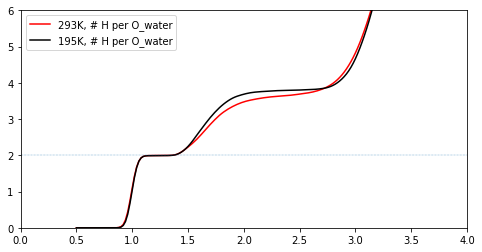

In [276]:
#f, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(8,10))

f = plt.figure(figsize=(8,4))
plot_w_label(numCoors_02, temp = 'RT',pair=('O_water','H'))
#plot_w_label(numCoors_02, temp = 'RT',pair=('O_hydronium','H'),linestyle = '--')
plot_w_label(numCoors_02, temp = 'LT',pair=('O_water','H'))
#plot_w_label(numCoors_02, temp = 'LT',pair=('O_hydronium','H'),linestyle = '--')

plt.legend()
plt.xlim(0.,4)
plt.ylim(0,6)
plt.axhline(y = 2, linestyle = '-.',linewidth = 0.3)

plt.show()

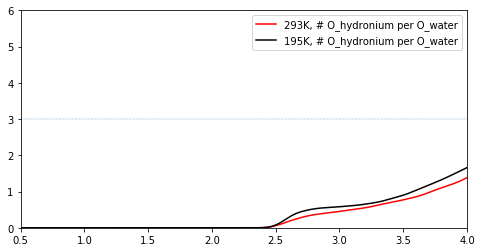

In [279]:
#f, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(8,10))

f = plt.figure(figsize=(8,4))
plot_w_label(numCoors_02, temp = 'RT',pair=('O_water','O_hydronium'))
plot_w_label(numCoors_02, temp = 'LT',pair=('O_water','O_hydronium'))

plt.legend()
plt.xlim(0.5,4.0)
plt.ylim(0,6)
plt.axhline(y = 3, linestyle = '-.',linewidth = 0.3)

plt.show()

In [ ]:
#f, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(8,10))

f = plt.figure(figsize=(8,4))
plot_w_label(numCoors_02, temp = 'RT',pair=('O_hydronium','O_water'))
plot_w_label(numCoors_02, temp = 'RT',pair=('O_hydronium','H'),linestyle = '--')
plot_w_label(numCoors_02, temp = 'LT',pair=('O_hydronium','O_water'))
plot_w_label(numCoors_02, temp = 'LT',pair=('O_hydronium','H'),linestyle = '--')

plt.legend()
plt.xlim(0.5,6.0)
plt.ylim(0,10)
plt.axhline(y = 3, linestyle = '-.',linewidth = 0.3)

plt.show()

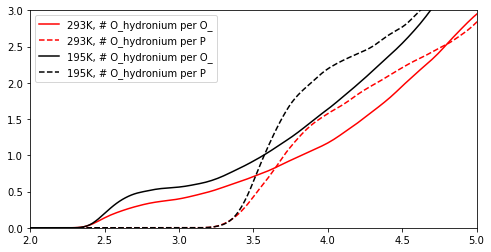

In [251]:
f = plt.figure(figsize=(8,4))
plot_w_label(numCoors_02, temp = 'RT',pair=('O_','O_hydronium'))
plot_w_label(numCoors_02, temp = 'RT',pair=('P','O_hydronium'),linestyle = '--')
plot_w_label(numCoors_02, temp = 'LT',pair=('O_','O_hydronium'))
plot_w_label(numCoors_02, temp = 'LT',pair=('P','O_hydronium'),linestyle = '--')

plt.legend()
plt.xlim(2.,5)
plt.ylim(0,3)
#plt.axhline(y = 4, linestyle = '-.',linewidth = 0.3,color = 'black')
#plt.axhline(y = 2, linestyle = '-.',linewidth = 0.3,color = 'black')

plt.show()

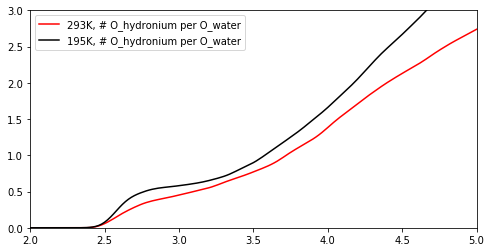

In [277]:
f = plt.figure(figsize=(8,4))
plot_w_label(numCoors_02, temp = 'RT',pair=('O_water','O_hydronium'))
plot_w_label(numCoors_02, temp = 'LT',pair=('O_water','O_hydronium'))

plt.legend()
plt.xlim(2.,5)
plt.ylim(0,3)
#plt.axhline(y = 4, linestyle = '-.',linewidth = 0.3,color = 'black')
#plt.axhline(y = 2, linestyle = '-.',linewidth = 0.3,color = 'black')

plt.show()

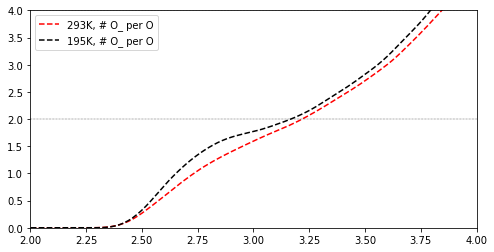

In [207]:
f = plt.figure(figsize=(8,4))
plot_w_label(numCoors_02, temp = 'RT',pair=('O_','O'),linestyle = '--')
plot_w_label(numCoors_02, temp = 'LT',pair=('O_','O'),linestyle = '--')

plt.legend()
plt.xlim(2,4)
plt.ylim(0,4)
plt.axhline(y = 4, linestyle = '-.',linewidth = 0.3,color = 'black')
plt.axhline(y = 2, linestyle = '-.',linewidth = 0.3,color = 'black')

plt.show()

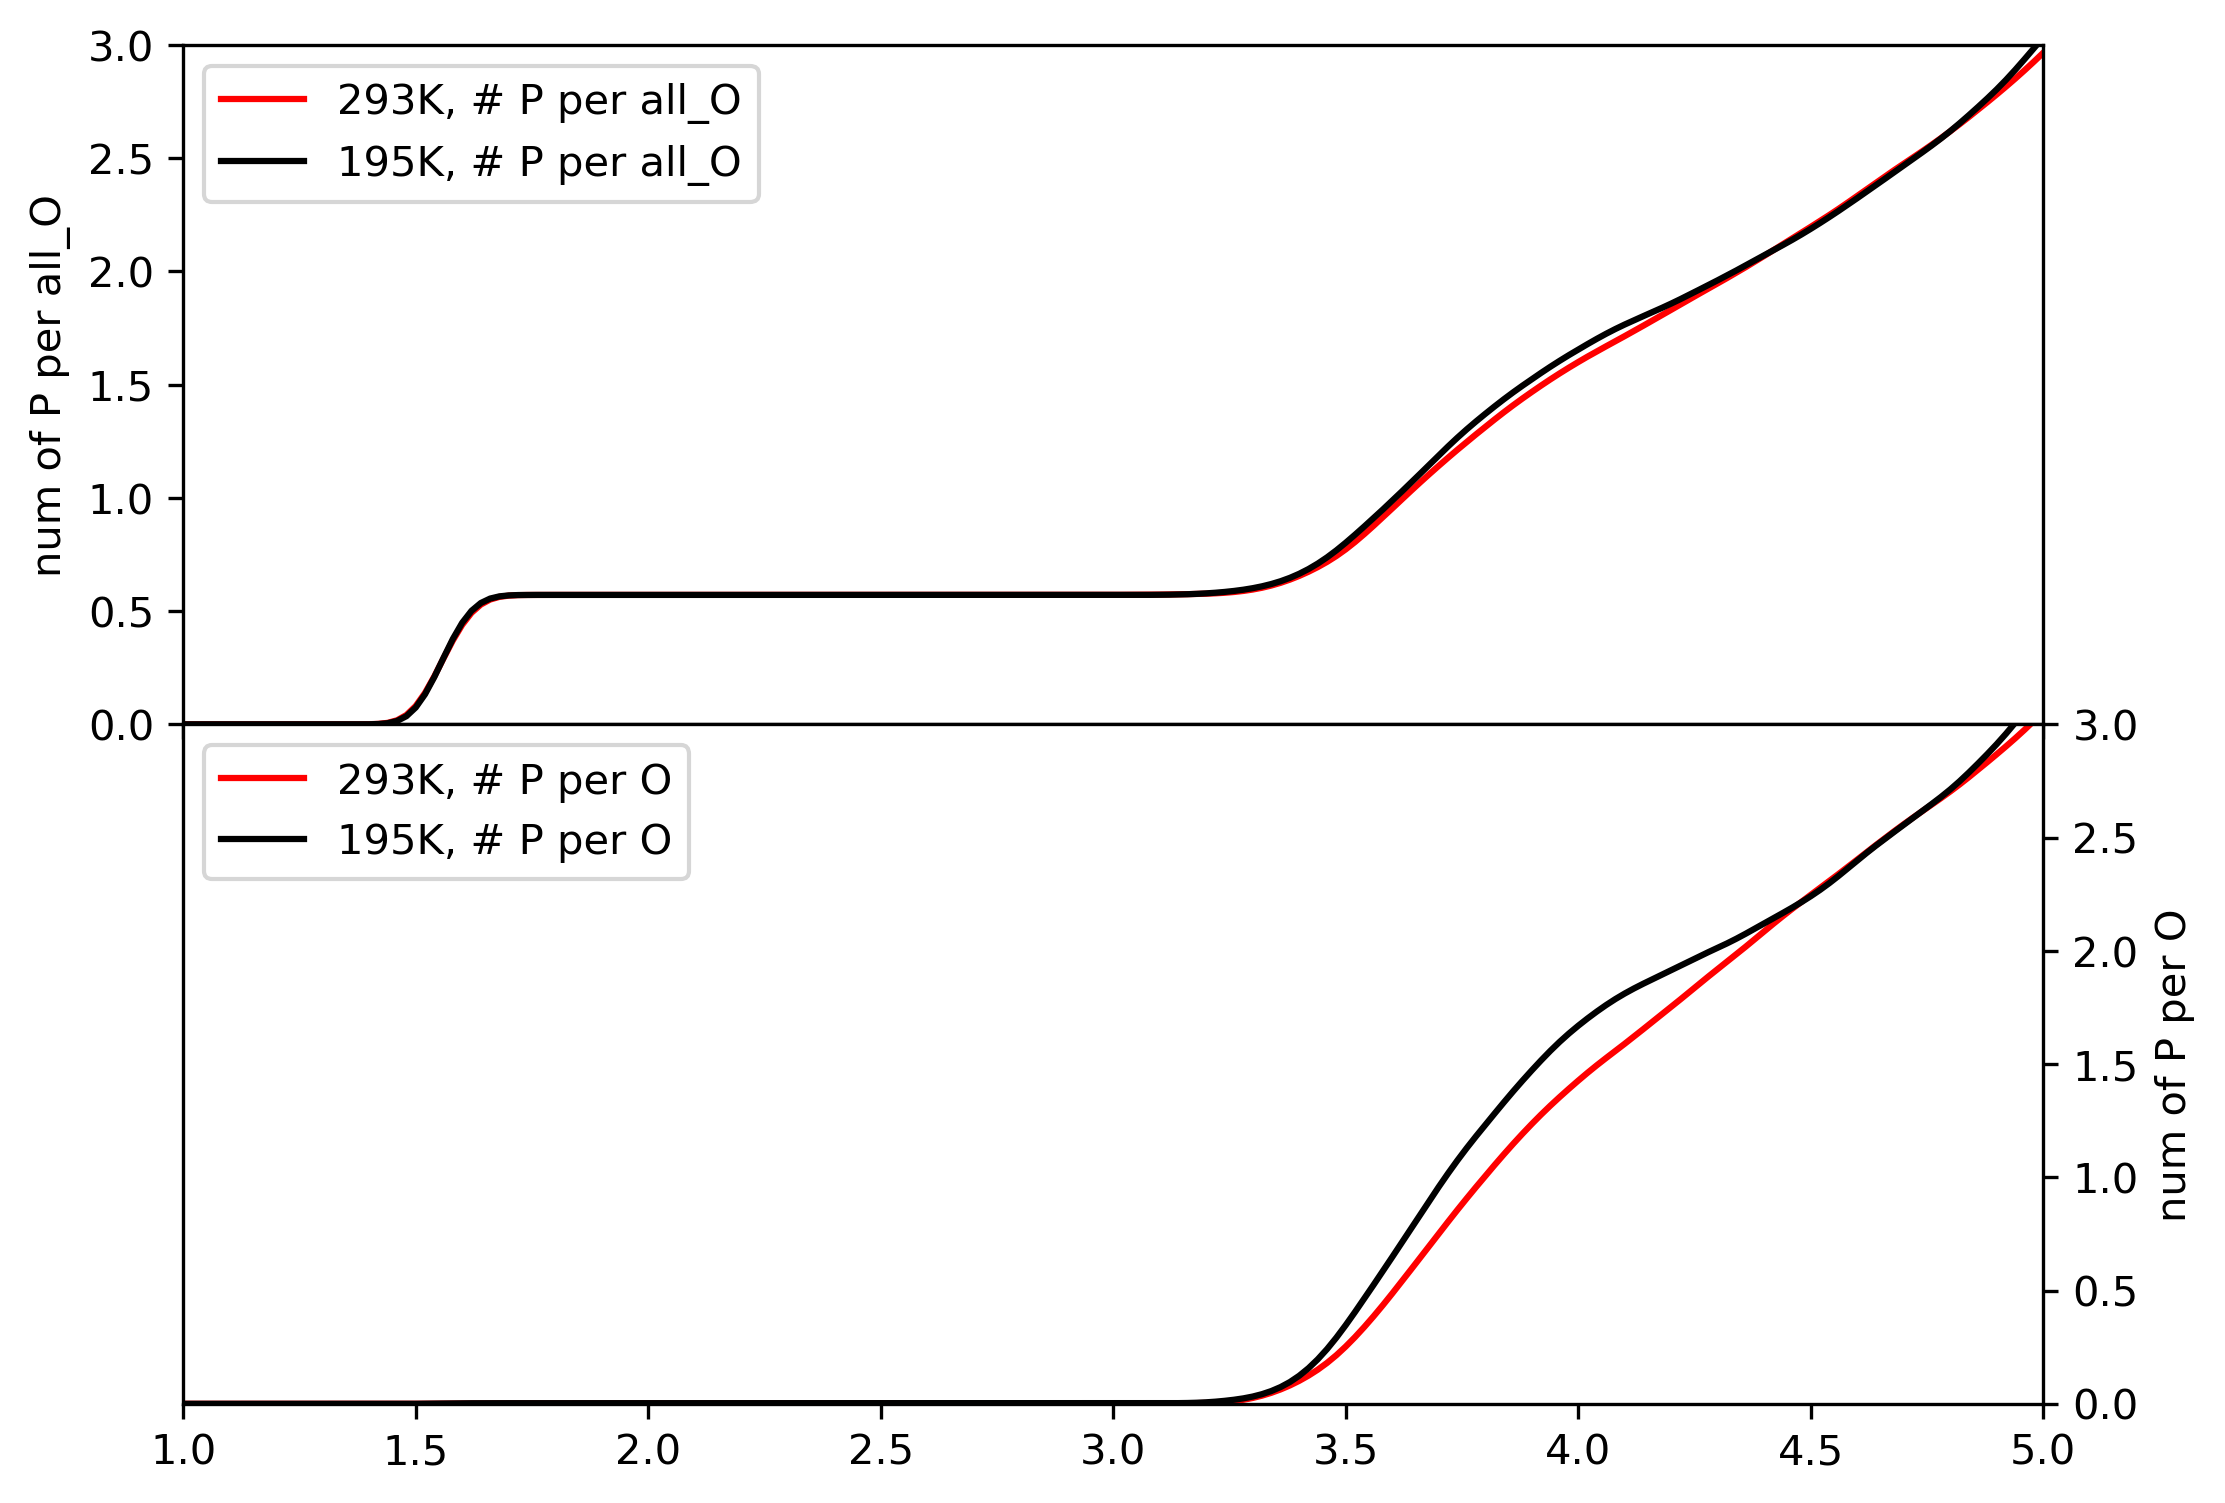

In [197]:
# # of O per Li, # of Li per Cl and # of Cl per H
pairs_plot = [('all_O', 'P'),('O', 'P')]#[('Li','all_O'),('Cl','Li'),('H','Cl')]
y_max = [3,3,3]
f, axs = plt.subplots(len(pairs_plot), 1, sharex=True,figsize=(8,3*len(pairs_plot)),dpi=300)
plt.subplots_adjust(hspace=0)
plt.xlim(1,5)
for i, (e1,e2) in enumerate(pairs_plot):
    plot_w_label(numCoors_02, temp = 'RT',pair=(e1,e2),ax = axs[i])
    plot_w_label(numCoors_02, temp = 'LT',pair=(e1,e2),ax = axs[i])
    axs[i].set_ylabel('num of '+e2+' per '+e1)
    axs[i].set_ylim(0,y_max[i])
    axs[i].legend(loc="upper left")
    if i%2:
        axs[i].yaxis.tick_right()
        axs[i].yaxis.set_label_position("right") 

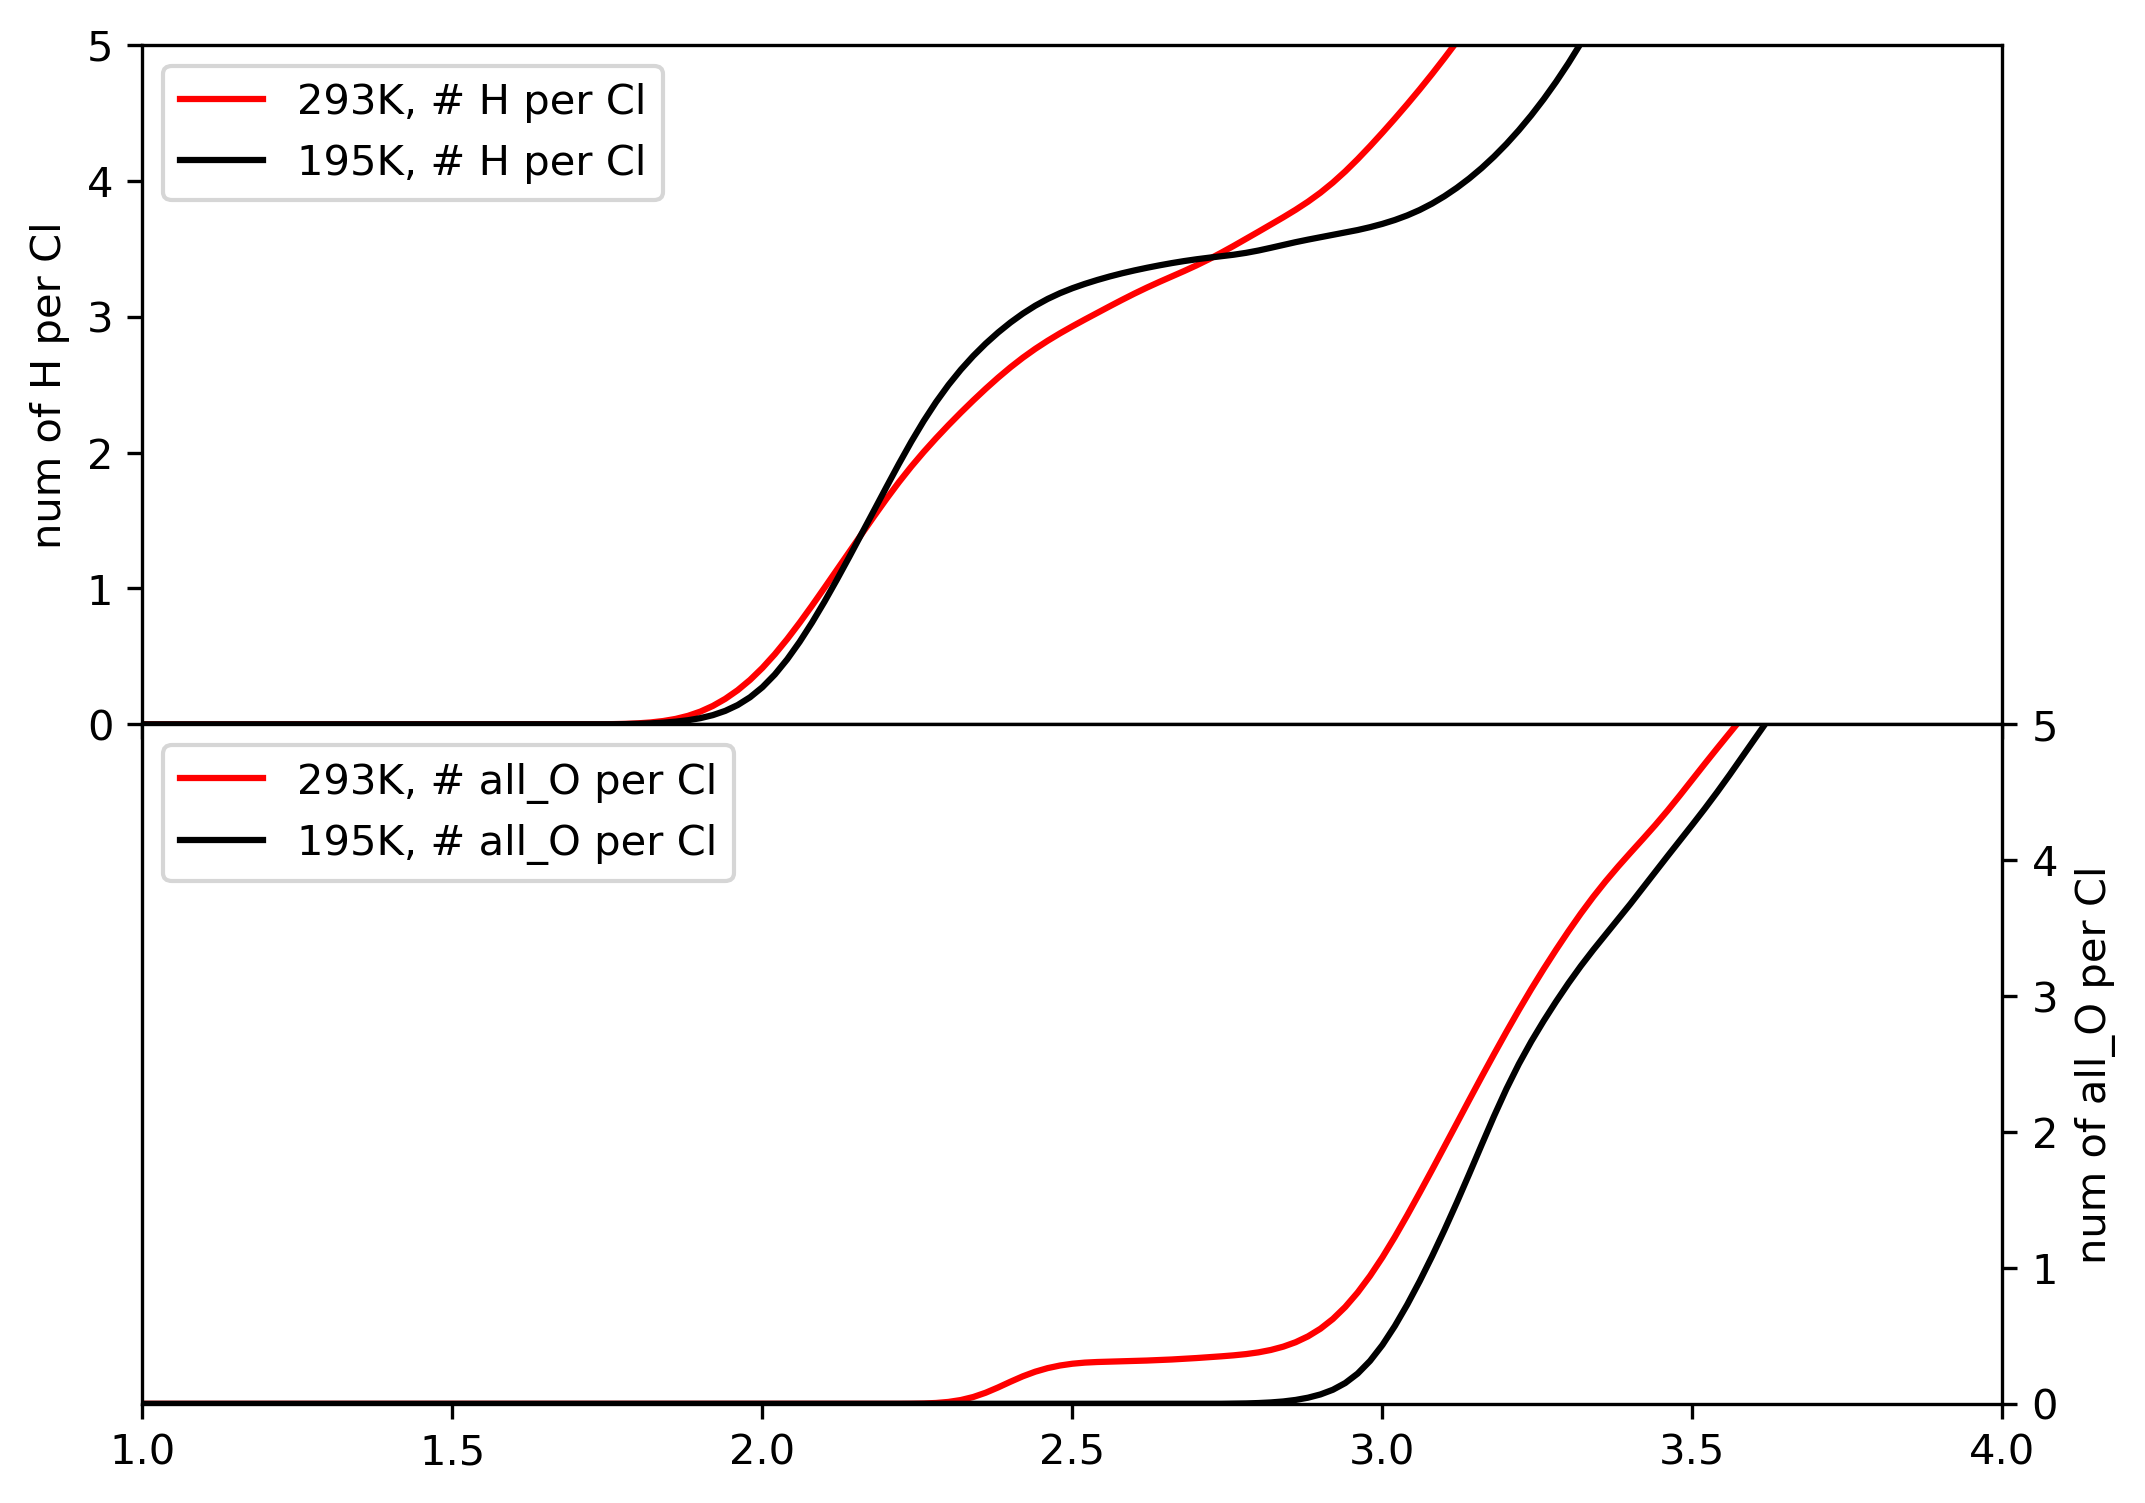

In [113]:
# # of O per Li, # of Li per Cl and # of Cl per H
pairs_plot = [('Cl','H'),('Cl','all_O')]
y_max = [5,5,3]
f, axs = plt.subplots(len(pairs_plot), 1, sharex=True,figsize=(8,3*len(pairs_plot)),dpi=300)
plt.subplots_adjust(hspace=0)
plt.xlim(1,4)
for i, (e1,e2) in enumerate(pairs_plot):
    plot_w_label(numCoors_02, temp = 'RT',pair=(e1,e2),ax = axs[i])
    plot_w_label(numCoors_02, temp = 'LT',pair=(e1,e2),ax = axs[i])
    axs[i].set_ylabel('num of '+e2+' per '+e1)
    axs[i].set_ylim(0,y_max[i])
    axs[i].legend(loc="upper left")
    if i%2:
        axs[i].yaxis.tick_right()
        axs[i].yaxis.set_label_position("right") 

In [281]:
for t in numCoors_02:
    res = np.array([numCoors_02[t]['x']]).T
    header = ['distance( r Angstram )']
    for e in numCoors_02[t]['ys']:
        header.append(e)
        res = np.concatenate((res,np.array([numCoors_02[t]['ys'][e]]).T),axis=1)
    np.savetxt(numCoors_02[t]['Tem']+'_coorination_number_H3PO4.csv', res, delimiter=',', header=','.join(header))

In [160]:
res[:,0]

array([0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64, 0.66, 0.68, 0.7 ,
       0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86, 0.88, 0.9 , 0.92,
       0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08, 1.1 , 1.12, 1.14,
       1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 , 1.32, 1.34, 1.36,
       1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52, 1.54, 1.56, 1.58,
       1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72, 1.74, 1.76, 1.78, 1.8 ,
       1.82, 1.84, 1.86, 1.88, 1.9 , 1.92, 1.94, 1.96, 1.98, 2.  , 2.02,
       2.04, 2.06, 2.08, 2.1 , 2.12, 2.14, 2.16, 2.18, 2.2 , 2.22, 2.24,
       2.26, 2.28, 2.3 , 2.32, 2.34, 2.36, 2.38, 2.4 , 2.42, 2.44, 2.46,
       2.48, 2.5 , 2.52, 2.54, 2.56, 2.58, 2.6 , 2.62, 2.64, 2.66, 2.68,
       2.7 , 2.72, 2.74, 2.76, 2.78, 2.8 , 2.82, 2.84, 2.86, 2.88, 2.9 ,
       2.92, 2.94, 2.96, 2.98, 3.  , 3.02, 3.04, 3.06, 3.08, 3.1 , 3.12,
       3.14, 3.16, 3.18, 3.2 , 3.22, 3.24, 3.26, 3.28, 3.3 , 3.32, 3.34,
       3.36, 3.38, 3.4 , 3.42, 3.44, 3.46, 3.48, 3.

In [280]:
header = ['distance( r Angstram )']
for i,[e1,e2] in enumerate(pairs):
    _temp = np.array([num_C['num of '+ e2 + ' per '+e1][0]])
    res = np.concatenate((res,_temp.T),axis = 1)
    _temp = np.array([num_C['num of '+ e2 + ' per '+e1][1]])
    res = np.concatenate((res,_temp.T),axis = 1)
    header = header+['num of '+ e2 + ' per '+e1+' 195K','num of '+ e2 + ' per '+e1+' 293K']
np.savetxt('coorination number_H3PO4.csv', res, delimiter=',', header=','.join(header))

NameError: name 'num_C' is not defined

In [210]:
from collections import Counter
Counter(x_RT_op[:,:,0].flatten())

Counter({'Li': 130000,
         'Cl': 130000,
         'O_Li': 440334,
         'O': 479666,
         'H': 1840000})

In [209]:
367116/(367116+552884)

0.3990391304347826

In [211]:
440334/(440334+479666)

0.4786239130434783

In [212]:
(367116+552884)/92

10000.0

In [216]:
x_RT_op_H = x_RT_op.copy()
for i in range(len(x_RT_op)):
    H_Li_idx =np.array(pair_find(x_RT_op[i], b_RT, ['H','O_Li'], r_cutoff = 1.28))
    H_Li_idx =  H_Li_idx - 1
    H_idxs = np.where(x_RT_op[i][:,0]=='H')[0]
    x_RT_op_H[i,H_idxs[H_Li_idx],0] = 'H_Li'

KeyboardInterrupt: 

In [ ]:
x_LT_op_H = x_LT_op.copy()
for i in range(len(x_LT_op)):
    H_Li_idx =np.array(pair_find(x_LT_op[i], b_LT, ['H','O_Li'], r_cutoff = 1.28))
    H_Li_idx =  H_Li_idx - 1
    H_idxs = np.where(x_LT_op[i][:,0]=='H')[0]
    x_LT_op_H[i,H_idxs[H_Li_idx],0] = 'H_Li'

In [ ]:
np.save('final_data/exam_02_RT_H_modified.npy',x_RT_op_H)
np.save('final_data/exam_02_LT_H_modified.npy',x_LT_op_H)

In [234]:
O_As_LT = [0,0,0,0,0,0,0]
O_LT=0
for i in range(-500,-1):
    atoms = x_LT_op[i]
    Os = np.where(atoms[:,0]=='O')[0]
    Hs = np.where(atoms[:,0]=='H')[0]
    O_LT+=len(Os)
    Os = atoms[Os,1:]
    Hs = atoms[Hs,1:]
    for O in Os:
        ds = distance(b_LT, O, Hs)
        ds = ds[ds<=1.9]
        O_As_LT[int(len(ds))-2]+=1

In [238]:
O_As_LT, sum(O_As_LT), O_LT

([244, 7946, 19737, 17, 0, 0, 0], 27944, 27944)

In [241]:
O_As = [0,0,0,0,0,0,0]
O_RT=0
for i in range(-500,-1):
    atoms = x_RT_op[i]
    Os = np.where(atoms[:,0]=='O')[0]
    Hs = np.where(atoms[:,0]=='H')[0]
    O_RT+=len(Os)
    
    Os = atoms[Os,1:]
    Hs = atoms[Hs,1:]
    for O in Os:
        ds = distance(b_RT, O, Hs)
        ds = ds[ds<=1.9]
        O_As[max(int(len(ds))-2,0)]+=1

In [242]:
sum(O_As), O_RT

(23542, 23542)

In [244]:
[e/sum(O_As) for e in O_As]

[0.1837991674454167,
 0.44754056579729845,
 0.36428510746750487,
 0.004375159289779967,
 0.0,
 0.0,
 0.0]

In [245]:
[e/sum(O_As_LT) for e in O_As_LT]

[0.008731749212711137,
 0.28435442313197823,
 0.7063054680790152,
 0.000608359576295448,
 0.0,
 0.0,
 0.0]

# charge density

In [314]:
chr_dir = '/rhome/wzhan097/bigdata/proton_battery/charge'
tem = 'LT'
model = 'case1'
charge = '_pos1' #'_neg1', ''
file = 'CHGCAR'

In [302]:
import subprocess
def read_chargeD(file_dir=os.path.join(chr_dir,tem,model)):
    cmd = 'grep -n "  160  160  160" '+os.path.join(file_dir,file)
    idx = int(str(subprocess.check_output(cmd, shell=True))[2:].split(':')[0])
    cmd = 'grep -n "augmentation" '+os.path.join(file_dir,file)
    idx_end = int(str(subprocess.check_output(cmd, shell=True))[2:].split(':')[0])
    with open(os.path.join(file_dir,file),'r') as f:
        lines = f.readlines()[idx:idx_end-1]
    data = [[float(e) for e in s.split()] for s in lines]
    return np.array(data)

In [318]:
for charge in ['_pos2','_pos3','_pos4','_pos5']:#['case1']:#,'case3','case4','case5']:
    file_dir=os.path.join(chr_dir,tem,model)
    #chrD_neg = read_chargeD(file_dir+'_neg1')
    chrD = read_chargeD(file_dir)
    chrD_pos = read_chargeD(file_dir+charge)
    chgcar_write(chrD_pos-chrD,filename='CHGCAR_diff'+charge+'_'+tem+'_'+model)
    #chgcar_write(chrD_neg-chrD,filename='CHGCAR_diff_neg1_'+tem+'_'+model)

In [ ]:
def chgcar_write(charges,filename = 'CHGCAR_diff'):
    newlines = ['\t'.join(map(str,e))+'\n' for e in charges]
    cmd = 'grep -n "  160  160  160" '+os.path.join(file_dir,file)
    idx = int(str(subprocess.check_output(cmd, shell=True))[2:].split(':')[0])
    cmd = 'grep -n "augmentation" '+os.path.join(file_dir,file)
    idx_end = int(str(subprocess.check_output(cmd, shell=True))[2:].split(':')[0])
    with open(os.path.join(file_dir,file),'r') as f:
        lines = f.readlines()
        lines[idx:idx_end-1] = newlines
    with open(filename,'w+') as f:
        f.writelines(lines)
    return lines

In [308]:
1

1

In [ ]:
case1_neg1/OUTCAR:  energy  without entropy=    -4337.87403993  energy(sigma->0) =    -4337.90684848
case1_neg2/OUTCAR:  energy  without entropy=    -2425.86653351  energy(sigma->0) =    -2425.93350953
case1_neg3/OUTCAR:  energy  without entropy=    -1704.84906638  energy(sigma->0) =    -1704.88513382
case1_neg4/OUTCAR:  energy  without entropy=    -2847.11283856  energy(sigma->0) =    -2847.17305079
case1_neg5/OUTCAR:  energy  without entropy=    -2630.86997453  energy(sigma->0) =    -2630.89186017
case1/OUTCAR:  energy  without entropy=    -3713.82730012  energy(sigma->0) =    -3713.88649948
case1_pos1/OUTCAR:  energy  without entropy=    -1766.01299293  energy(sigma->0) =    -1766.03371127
case1_pos2/OUTCAR:  energy  without entropy=    -1410.94063753  energy(sigma->0) =    -1410.98159565
case1_pos3/OUTCAR:  energy  without entropy=    -1408.12743815  energy(sigma->0) =    -1408.18544496
case1_pos4/OUTCAR:  energy  without entropy=    -1405.20083306  energy(sigma->0) =    -1405.27449334
case1_pos5/OUTCAR:  energy  without entropy=    -1402.19280797  energy(sigma->0) =    -1402.27932182

In [ ]:
def get_freq()

def OH_freq(data, w_length_plot = np.linspace(2500,4500,300)):
    
    light_c = 29979245800
    
    mol_type_time = np.load('LiCl/'+sys_ind+'/'+Tem+"_O_form"+temp_tag+".npy")

    period,_ = water_form_lifetime(mol_type_time, water_form = water_form)
    Os = if_OH_bond = np.load('LiCl/'+sys_ind+'/'+Tem+"_O_inds"+temp_tag+".npy")


    angles_tag = []
    for i in set(Os):
        n = len(np.where(Os==i)[0])
        _n = 0
        for _i in range(n):
            _n+=_i
        angles_tag +=[i]*_n
    angles_tag = np.array(angles_tag)

    outfile = 'LiCl/'+sys_ind+'/'+Tem+"_OH_flg"+temp_tag+".npy"
    if_OH_bond = np.load(outfile)
    outfile = 'LiCl/'+sys_ind+'/'+Tem+"_HOH_flg"+temp_tag+".npy"
    if_HOH_angle = np.load(outfile)
    outfile = 'LiCl/'+sys_ind+'/'+Tem+"_OH"+temp_tag+".npy"
    OH_bond = np.load(outfile)
    outfile = 'LiCl/'+sys_ind+'/'+Tem+"_HOH"+temp_tag+".npy"
    HOH_angle = np.load(outfile)
    bond_mat = []
    angle_mat = []
    bond_list = []
    angle_list = []
    for i,ps in enumerate(period):
        #print(i)
        for p in ps:
            _flg = if_OH_bond[p[0]:p[1],np.where(Os==i)[0]]
            _bondL =  OH_bond[p[0]:p[1],np.where(Os==i)[0]]
            _i = np.where(_flg[0]==1)[0]

            for l in _bondL[:,_i].T:
                bond_list.append([i,l])

            _flg = if_HOH_angle[p[0]:p[1],np.where(angles_tag==i)[0]]
            _angleA =  HOH_angle[p[0]:p[1],np.where(angles_tag==i)[0]]
            _i = np.where(_flg[0]==1)[0]
            for l in _angleA[:,_i].T:
                angle_list.append([i,l])
                
    x_int = np.linspace(2500, 4500, 20000)
    y_int = np.zeros(x_int.shape,dtype='float64')

    bond_list = np.array(bond_list)
    res_data = np.zeros(w_length_plot.shape)
    for idx in range(len(bond_list)):#range(len(period_len)):
        temp_data=bond_list[idx,1]  
        vel = temp_data[1:]-temp_data[:-1]
        fft = np.fft.fft(vel)
        ps = fft*np.conjugate(fft)
        acf = np.fft.ifft(ps)

        signal = vel #divide by maximum abs(vel)
        fourier = np.fft.fft(signal)
        n = signal.size
        timestep = 1E-3
        freq = 2*np.fft.fftfreq(n, d=timestep)#*np.sqrt(17/9)

        w_length = (freq*1e12)/light_c #
        for dp_x,dp_y in zip(w_length,ps):
            res_data+=dp_y.real*gaussian(w_length_plot,dp_x,10*dp_y.real)#/len(bond_list[idx,-1])
    
    angle_list = np.array(angle_list)
    res_data_ang = np.zeros(w_length_plot.shape)
    
    for idx in range(len(angle_list)):#range(len(period_len)):
        temp_data=angle_list[idx,1]  
        vel = temp_data[1:]-temp_data[:-1]
        fft = np.fft.fft(vel)
        ps = fft*np.conjugate(fft)
        acf = np.fft.ifft(ps)

        signal = vel #divide by maximum abs(vel)
        fourier = np.fft.fft(signal)
        n = signal.size
        timestep = 1E-3
        freq = 2*np.fft.fftfreq(n, d=timestep)#*np.sqrt(17/9)

        w_length = (freq*1e12)/light_c #
        for dp_x,dp_y in zip(w_length,ps):
            res_data_ang+=dp_y.real*gaussian(w_length_plot,dp_x,10*dp_y.real)#/len(angle_list[idx,-1])
            
    bond_list = np.array(bond_list)
    period_len = np.array([len(e) for e in bond_list[:,-1]])
    #plt.plot(w_length_plot,res_data,label='plot/DDAA/'+'RT_02')
    #plt.xlim(2500,4500)
    return res_data/sum(period_len), res_data_ang/sum(np.array([len(e) for e in bond_list[:,-1]]))
    return res_data, res_data_ang




